In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()

os.chdir( os.path.join( '..', '..', 'notebook_format' ) )
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

# list of stop words
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
stoplist = set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS) )

from operator import itemgetter
from gensim import corpora
from gensim.models import LdaModel

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,gensim,nltk,scikit-learn

Ethen 2016-08-17 10:40:58 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
gensim 0.13.1
nltk 3.2.1
scikit-learn 0.17.1


# Topic Modeling

What is Topic Modeling? Topic modeling is a technique for taking some unstructured text and automatically extracting its common themes. It is a great way to get a bird's eye view on a large text collection.

The major feature distinguishing the topic model from other clustering methods is the notion of mixed membership. A lot of clustering models have assumed that each data point belongs to a single cluster. **k-means** determines membership simply by shortest distance to the cluster center, and **gaussian mixture models** assumes that each data point is drawn from one of their component mixture distributions. In many cases, though, it is more realistic to think of data as genuinely belonging to more than one cluster or category - for example, if we have a model for text data that includes both "Politics" and "World News" categories, then an article about a recent meeting of the United Nations should have membership in both categories rather than being forced into just one.

Topic modeling assumes that a topic is a probability distribution over the vocabulary. For example, if we were to create three topics for the Harry Potter series of books manually, we might come up with something like this:

- (the Muggle topic) 50% "Muggle", 25% "Dursey", 10% "Privet", 5% "Mudblood"...
- (the Voldemort topic) 65% "Voldemort", 12% "Death", 10% "Horcrux", 5% "Snake"...
- (the Harry topic) 42% "Harry Potter", 15% "Scar", 7% "Quidditch", 7% "Gryffindor"...

In the same way, we can represent individual documents as a probability distribution over topics. For example, Chapter 1 of Harry Potter book 1 introduces the Dursley family and has Dumbledore discuss Harry’s parent’s death. If we take this chapter to be a single document, it could be broken up into topics like this: 40% Muggle topic, 30% Voldemort topic, and the remaining 30% is the Harry topic.

Of course, we don’t want to extract the topics and document probabilities by hand like this. We want the machine to do it automatically using our unlabelled text collection as the only input. Because there is no document labeling nor human annotations, topic modeling an example of an unsupervised machine learning technique.


## Getting Started

We'll now start exploring one popular algorithm for doing topic model, namely **Latent Dirichlet Allocation**. Latent Dirichlet Allocation (LDA) requires documents to be represented as a bag of words (bow), which ignores word ordering in the document but retains information on how many times each word appears. Furthermore, words such as 'the', 'a', or 'and' are by far the most frequent, but they appear so commonly in the English language that they tell us almost nothing about how similar or dissimilar two documents might be. Or there may be words that only appear one of twice in the entire corpus and we simply don't have enough data to about these words to learn a meaningful output.

Therefore, before we train our LDA model, it is common to preprocess the data with two steps: first, we will create a bag of words representation for each article, and then we will remove the common and uncommon words that don't help us to distinguish between documents.

We'll first play around a toy corpus of 11 documents (already in the bag of words representation) to familiarize ourselves with the api. In the toy corpus presented, there are 5 documents that are river related and 6 finance related. The interesting part is that the corpus contains the word "bank" which could mean "a financial institution" or "a river bank". A good topic modeling algorithm should be able to the difference between these two meanings based on context.

In [3]:
# each nested list represents the word of a document
texts = [['bank','river','shore','water'],
        ['river','water','flow','fast','tree'],
        ['bank','water','fall','flow'],
        ['bank','bank','water','rain','river'],
        ['river','water','mud','tree'],
        ['money','transaction','bank','finance'],
        ['bank','borrow','money'], 
        ['bank','finance'],
        ['finance','money','sell','bank'],
        ['borrow','sell'],
        ['bank','loan','sell']]

# build the dictionary and convert the documents 
# to bag of words (bow) representation using the dictionary
texts_dictionary = corpora.Dictionary(texts)
texts_corpus = [ texts_dictionary.doc2bow(text) for text in texts ]

The following code chunk trains the LDA model using our corpus and dictionary. We set the number of topics to be 2, and expect to see one related to river banks, and one has to do with financial banks.

In [4]:
# train the model
# the more iteration, the more stable the model
# becomes, but of course takes longer to train
texts_model = LdaModel( 
    texts_corpus, 
    id2word = texts_dictionary, 
    num_topics = 2, 
    iterations = 100 
)

In [5]:
# we can use num_words to limit the listed 
# number of most probable words 
texts_model.show_topics()

[(0,
  '0.177*bank + 0.124*water + 0.083*money + 0.082*flow + 0.074*finance + 0.066*river + 0.056*fall + 0.053*sell + 0.051*tree + 0.041*fast'),
 (1,
  '0.180*bank + 0.109*river + 0.093*water + 0.087*sell + 0.069*finance + 0.068*borrow + 0.062*money + 0.056*tree + 0.046*mud + 0.043*loan')]

After showing the topics, it will output the most probable words that appear in each topic. We see our LDA model has given us near perfect results. Bank is the most influential word in both the topics and other words help define what kind of bank we are talking about.

We can also use the function `get_term_topics` and `get_document_topics` to further evaluate our result.

`get_term_topics` returns the odds of that particular word belonging to a particular topic. A few examples:

In [6]:
print( texts_model.get_term_topics('water') )
print( texts_model.get_term_topics('bank') )

[(0, 0.1071109088251762), (1, 0.078187927256642711)]
[(0, 0.16146612765493842), (1, 0.16609454796956596)]


Since the word bank is likely to be in both the topics, the values returned are also very similar.

The `get_document_topics` method outputs the topic distribution of the document. Apart from this, it also let us know the topic distribution for each word in the document. Let us test this with two different documents which have the word bank in it, one in the finance context and one in the river context.

In [7]:
# before we can infer topic distributions on new, unseen documents
# we need to convert it to bag of words format first
bow_water = ['bank', 'water', 'bank']
bow = texts_model.id2word.doc2bow(bow_water) 
doc_topics, word_topics, phi_values = texts_model.get_document_topics(bow, per_word_topics = True)

# note that doc_topics equivalent to simply calling model[bow]
print( 'document topics: ', doc_topics )
print()

for word_id, topic in word_topics:
    # access the word with the word id
    print( texts_model.id2word[word_id], topic )

print()

for word_id, topic in phi_values:
    print( texts_model.id2word[word_id], topic )

document topics:  [(0, 0.72140314459079591), (1, 0.27859685540920409)]

bank [0, 1]
water [0, 1]

bank [(0, 1.5551644874019783), (1, 0.4448355125980214)]
water [(0, 0.83126839476582681), (1, 0.16873160523417316)]


What do all these output mean? 

- `doc_topics` shows that this document has a higher probability of belonging to topic 0.
- When `per_word_topics` is set as `True`, it also returns a `word_topics`. This variable captures the word id followed by a list sorted with the most likely topic id. From the output, it means both our word bank and water is more likely to be in topic 0 than topic 1.
- We could also list out the `phi_values`. Compared with `word_topics`, it adds the information of the probability of the word belonging to a particular topic. Note that it is scaled by feature length (the word bank appeared 2 times, hence the value of the probability will add up to 2).

let's now do the same thing with a second document, bow_finance.

In [8]:
bow_finance = ['bank', 'finance']
bow = texts_model.id2word.doc2bow(bow_finance) # convert to bag of words format first
doc_topics, word_topics, phi_values = texts_model.get_document_topics(bow, per_word_topics = True)
word_topics

[(2, [0, 1]), (10, [0, 1])]

Since the word bank is now used in a financial context, the most probable topic for the word immedietly swaps to being topic 1. We've seen quite clearly that based on the context, the most likely topic associated with a word can change. This differs from our previous method, `get_term_topics`, where it is a 'static' topic distribution.

But note that, each word in a document is only given one topic distribution. For example, the sentence 'the bank by the river bank' is assigned to topic 1, since every bank word will have the same distribution.

In [9]:
bow = texts_model.id2word.doc2bow([ 'the', 'bank', 'by', 'the', 'river', 'bank' ])
doc_topics, word_topics, phi_values = texts_model.get_document_topics(bow, per_word_topics = True)
word_topics

[(1, [1, 0]), (2, [1, 0])]

## Wiki Example

Let's dig deeper into this topic modeling technique using a larger dataset. To follow along please download the file from this [dropbox link](https://www.dropbox.com/s/mriz0nq35ore8cr/people_wiki.csv?dl=0).

In [10]:
# the file is placed one directory above this notebook,
# since it's also used by other notebooks
# change this if you liked
file = os.path.join( '..', 'people_wiki.csv' )
wiki = pd.read_csv(file)
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [11]:
# build the id2word dictionary and the corpus (map the word to id)
texts = wiki['text'].apply( lambda x: x.split(' ') ).tolist()
dictionary = corpora.Dictionary(texts)
print( 'number of unique tokens: ', len(dictionary) )

# remove stop words and words that appear only once 
stop_ids = [ dictionary.token2id[stopword] for stopword in stoplist
             if stopword in dictionary.token2id ]
dictionary.filter_tokens(stop_ids)

# filter out words that appear in less than 2 documents
dictionary.filter_extremes(no_below = 2)

# remove gaps in id sequence after words that were removed
dictionary.compactify()
print( 'number of unique tokens: ', len(dictionary) )

corpus = [ dictionary.doc2bow(text) for text in texts ]

number of unique tokens:  548561
number of unique tokens:  100000


After building the dictionary of word to id mapping and the corpus we can now train our model.

> Taken from the [gensim LDA documentation](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation).
>
> With gensim we can run online LDA, which is an algorithm that takes a chunk of documents, updates the LDA model, takes another chunk, updates the model etc. Online LDA can be contrasted with batch LDA, which processes the whole corpus (one full pass), then updates the model, then another pass, another update... The difference is that given a reasonably stationary document stream (not much topic drift), the online updates over the smaller chunks (subcorpora) are pretty good in themselves, so that the model estimation converges faster. As a result, we will perhaps only need a single full pass over the corpus: if the corpus has 3 million articles, and we update once after every 10,000 articles, this means we will have done 300 updates in one pass, quite likely enough to have a very accurate topics estimate.

The default parameter for the `LdaModel` is chunksize=2000, passes=1, update_every=1. 

- The model will update once (`update_every`) every 1 chunk (10,000 documents). We can set `update_every` to 0 if we wanted to perform batch LDA.
- `passes` corresponds to how many times each mini-batch will be given to LDA for training. Setting it to higher value allows LDA to see our corpus multiple times and is very handy for smaller corpora.

The method used to fit the LDA model is a randomized algorithm, which means that it involves steps that are random. Because of these random steps, the algorithm will be expected to yield slighty different output for different runs on the same data. Hence to make sure that the output are consistent and to save some time, We will save the model without having to rebuild it every single time.

```python
# for saving and loading the gensim LdaModel
model.save('model.lda')
model = LdaModel.load('model.lda')
```
<p>
<div class="alert alert-info">
Note that there is also the `LdaMulticore` model available, in case we want to use all CPU cores to parallelize and speed up model training. All its parameter is the same as the LdaModel we're using here.
</div>

In [12]:
# load the model if we've already trained it before
# takes around 2 min 2 sec if training from scratch
path = 'topic_model.lda'
if not os.path.isfile(path):
    topic_model = LdaModel( corpus, id2word = dictionary, num_topics = 10, iterations = 200 )
    topic_model.save(path)

topic_model = LdaModel.load(path)

### Identifying topic themes by top words

After building the model, we'll start by trying to identify the topics learned by our model. It is reasonable to hope that the model has been able to learn topics that corresponds to recognizable categories. In order to do this, we must first recall what exactly a 'topic' is in the context of LDA. 

To LDA, a topic is a probability distribution over words in the vocabulary; that is, each topic assigns a particular probability to every one of the unique words that appears in our data. Different topics will assign different probabilities to the same word: for instance, a topic that ends up describing science and technology articles might place more probability on the word 'university' than a topic that describes sports or politics. Looking at the highest probability words in each topic will thus give us a sense of its major themes. Ideally we would find that each topic is identifiable with some clear theme and that all the topics are relatively distinct.

In [13]:
# each list is a tuple containing the topic and word / probability list
topics = topic_model.show_topics( num_words = 10, formatted = False )
topics

[(0,
  [('album', 0.011658345894240184),
   ('released', 0.0093104282202488651),
   ('music', 0.0077885167859285849),
   ('band', 0.0075361034991478911),
   ('song', 0.005330685126680404),
   ('known', 0.0051475158938387765),
   ('best', 0.0048750061712574911),
   ('records', 0.0046782274108954037),
   ('songs', 0.0042742468704786421),
   ('played', 0.0042361105283486864)]),
 (1,
  [('minister', 0.0063804116446225297),
   ('government', 0.0056927036397906965),
   ('party', 0.005653588703463195),
   ('court', 0.0042620116998945412),
   ('years', 0.0041595662345608186),
   ('later', 0.0038287217293505658),
   ('political', 0.0036481664463826752),
   ('rights', 0.0036211583374656628),
   ('indian', 0.0035974838555140193),
   ('said', 0.00358126850541966)]),
 (2,
  [('university', 0.023199679577703171),
   ('member', 0.007875690307778873),
   ('served', 0.0075617710776014055),
   ('international', 0.0074190760161321366),
   ('president', 0.0073885301439813962),
   ('director', 0.0073341843

We can identify themes for each topic, some example:

- topic 0 includes words such as album, released, music. Possibly a music topic. 
- topic 4 includes words such as season, team, player, coach, etc. It's probably about about sports.
- topic 6 includes words such as state, served, election. Politics.

Recall that the main distinguishing feature for LDA, is it allows for mixed membership, which means that each document can partially belong to several different topics. For each document, topic membership is expressed as a vector of weights that sum to one; the magnitude of each weight indicates the degree to which the document represents that particular topic.

We'll explore this in our fitted model by looking at the topic distributions for a few example Wikipedia articles from our data set. We should find that these articles have the highest weights on the topics whose themes are most relevant to the subject of the article - for example, we'd expect an article on a politician to place relatively high weight on topics related to government, while an article about an athlete should place higher weight on topics related to sports or competition.

Here we'll predict the topic distribution for the article on Barack Obama:

In [14]:
# extract one document to serve as an example
obama = wiki.loc[ wiki['name'] == 'Barack Obama', 'text' ].tolist()[0].split()

# topic distribution for this document
obama_bow = topic_model.id2word.doc2bow(obama)
topic_model[obama_bow]

[(1, 0.32786982487321564),
 (2, 0.11506775467188431),
 (5, 0.010275044193177745),
 (6, 0.49890926901240856),
 (8, 0.010059484160222447),
 (9, 0.03656042097299976)]

As we can see the most probable topic associated with a politician is topic 6, which we labeled as politics. And if we look at the second most probable topic, topic 1, we can see words such as government, court which thankfully also makes sense (this is probably a topic about the government and the law).

### Measuring the importance of top words

We can learn more about topics by exploring how they place probability mass (which we can think of as a weight) on each of their top words.

We'll do this with two visualizations of the weights for the top words in each topic:
 - the weights of the top 100 words, sorted by the size
 - the total weight of the top 10 words

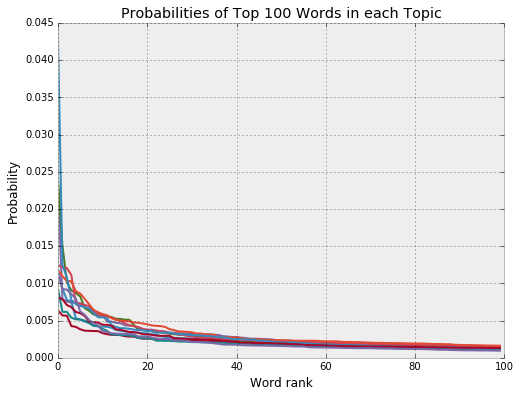

In [15]:
# top 100 words by weight in each topic
top_n_words = 100
topics = topic_model.show_topics( num_topics = 10, num_words = top_n_words, formatted = False )
for _, infos in topics:
    probs = [ prob for _, prob in infos ]
    plt.plot( range(top_n_words), probs )

plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')
plt.show()

In the above plot, each line corresponds to one of our ten topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10-20 words in each topic are assigned a much greater weight than the remaining words (remember from the preprocessing step that our vocabulary size was 100000).

Next we plot the total weight assigned by each topic to its top 10 words:

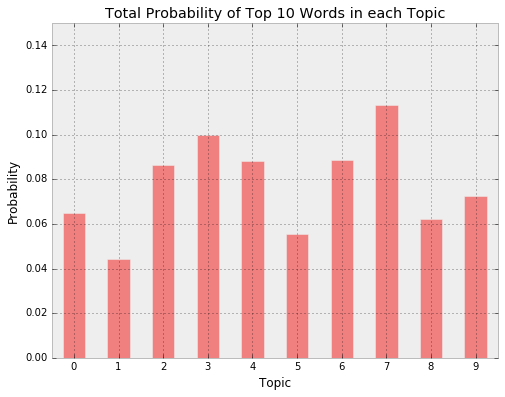

In [16]:
# total weight assigned by each topic to its top 10 words
top_probs = []
top_n_words = 10
topics = topic_model.show_topics( num_words = top_n_words, formatted = False )
for _, infos in topics:
    prob = sum([ prob for _, prob in infos ])
    top_probs.append(prob)

ind = np.arange(top_n_words)
width = 0.5

fig, ax = plt.subplots()

ax.bar( ind - (width / 2), top_probs, width, color = 'lightcoral' )
ax.set_xticks(ind)

plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Total Probability of Top 10 Words in each Topic')
plt.xlim(-0.5, 9.5)
plt.ylim(0, 0.15)
plt.show()

Here we see that, for our topic model, the top 10 words only account for a small fraction (in this case, between 4% and 10%) of their topic's total probability mass. So while we can use the top words to identify broad themes for each topic, we should keep in mind that in reality these topics are more complex than a simple 10-word summary.

### Understanding the role of LDA model hyperparameters

Finally, we'll take a look at the effect of the LDA model hyperparameters `alpha` and `eta` on the characteristics of our topic model. Recall that `alpha` is a parameter that controls the **prior distribution over topic weights in each document**, while `eta` is a parameter for the **prior distribution over word weights in each topic**. In gensim, both default to a symmetric, 1 / num_topics prior.

<p>
<div class="alert alert-warning">
Different packages ues different notations for these two hyperparameters (you'll see $\alpha$ (alpha), $\eta$ (eta), $\beta$ (beta), $\theta$ (theta), $\gamma$ (gamma) ....), hence you definitely check the documentation to see which one refers to the **document topic prior** and which one controls the **topic word prior**.
</div>

`alpha` and `eta` can be thought of as smoothing parameters when we compute how much each document "likes" a topic (in the case of `alpha`) or how much each topic "likes" a word (in the case of `gamma`). A higher `alpha` makes the document preferences "smoother" over topics, and a higher `eta` makes the topic preferences "smoother" over words.

Our goal in this section will be to understand how changing these parameter values affects the characteristics of the resulting topic model. 

We'll start with `alpha`. Since `alpha` is responsible for smoothing document preferences over topics, the impact of changing its value should be visible when we plot the distribution of topic weights for the same document under models fit with different `alpha` values. In the code below, we load topic models that have been trained using different settings of `alpha`, plot the (sorted) topic weights for the Wikipedia article on an example document (the same one we've used as an example to predict the topic distribution) under models with high (10), original (0.1), and low (0.001) settings of alpha.

In [17]:
path_alpha_high = 'topic_model_alpha_high.lda'
path_alpha_low = 'topic_model_alpha_low.lda'

if not os.path.isfile(path_alpha_high):
    topic_model_alpha_high = LdaModel( corpus, id2word = dictionary, 
                                       num_topics = 10, iterations = 200, alpha = 10 )
    topic_model_alpha_low  = LdaModel( corpus, id2word = dictionary, 
                                       num_topics = 10, iterations = 200, alpha = 0.001 )

    topic_model_alpha_high.save(path_alpha_high)
    topic_model_alpha_low.save(path_alpha_low)


topic_model_alpha_high = LdaModel.load(path_alpha_high)
topic_model_alpha_low  = LdaModel.load(path_alpha_low)

In [18]:
def sort_doc_topics( topic_model, doc ):
    """
    given a gensim LDA topic model and
    a document, obtain the predicted probability
    for each topic in sorted order
    """
    bow = topic_model.id2word.doc2bow(doc)
    
    # the default minimum_probability will clip out topics that
    # have a probability that's too small will get chopped off, 
    # which is not what we want here
    doc_topics = topic_model.get_document_topics( bow, minimum_probability = 0)
    doc_topics.sort( key = itemgetter(1), reverse = True )
    probs = [ prob for _, prob in doc_topics ]
    return probs

In [19]:
alpha_low     = sort_doc_topics( topic_model_alpha_low, obama )
alpha_default = sort_doc_topics( topic_model, obama )
alpha_high    = sort_doc_topics( topic_model_alpha_high, obama )

In [20]:
def param_barplot( a, b, c, ylim, param, xlab, ylab ):
    """
    plotting function for three topic models that
    have a different `param` value
    """
    ind = np.arange(len(a))
    width = 0.3
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    b1 = ax.bar( ind, a, width, color = 'lightskyblue' )
    b2 = ax.bar( ind + width, b, width, color = 'lightcoral' )
    b3 = ax.bar( ind + (2 * width), c, width, color = 'gold' )

    ax.set_xticks(ind + width)
    ax.set_xticklabels( range(len(a)) )
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
    ax.set_ylim(0, ylim)
    ax.legend( handles = [b1, b2, b3], 
               labels = ['low ' + param, 'default ' + param, 'high ' + param] )
    plt.tight_layout()
    plt.show()

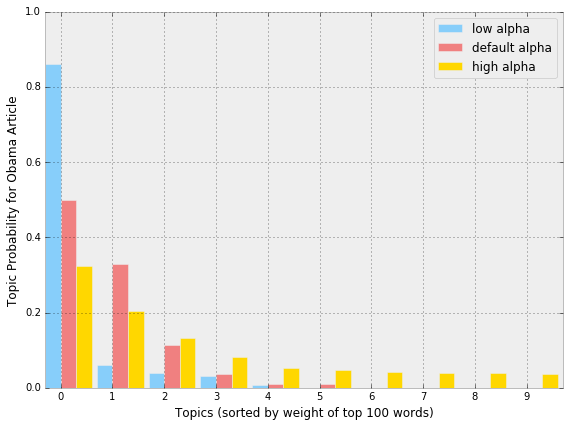

In [21]:
param_barplot( alpha_low, alpha_default, alpha_high,
               ylim = 1.0, param = 'alpha',
               xlab = 'Topics (sorted by weight of top 100 words)',
               ylab = 'Topic Probability for Obama Article' )

Here we can clearly see the smoothing enforced by the `alpha` parameter - notice that when `alpha` is low, most of the weight in the topic distribution for this article goes to a single topic, but when it is high, the weight is much more evenly distributed across the topics.

Just as we were able to see the effect of `alpha` by plotting topic weights for a document, we expect to be able to visualize the impact of changing `eta` by plotting word weights for each topic. In this case, however, there are far too many words in our vocabulary to do this effectively. Instead, we'll plot the total weight of the top 10 words and bottom 500 words for each topic in the high, original, and low `eta` models.

In [22]:
path_eta_high = 'topic_model_eta_high.lda'
path_eta_low = 'topic_model_eta_low.lda'

if not os.path.isfile(path_eta_high):
    topic_model_eta_high = LdaModel( corpus, id2word = dictionary, 
                                     num_topics = 10, iterations = 200, eta = 10 )
    topic_model_eta_low  = LdaModel( corpus, id2word = dictionary, 
                                     num_topics = 10, iterations = 200, eta = 0.001 )
                                 
    topic_model_eta_high.save(path_eta_high)
    topic_model_eta_low.save(path_eta_low)

topic_model_eta_high = LdaModel.load(path_eta_high)
topic_model_eta_low  = LdaModel.load(path_eta_low)

In [23]:
def get_top_word_weight( topic_model, top_n_words ):
    """
    total weight assigned by each topic to its top `top_n_words` words
    """
    top_probs = []
    topics = topic_model.show_topics( num_topics = 10, num_words = top_n_words, formatted = False )
    for _, infos in topics:
        prob = sum([ prob for _, prob in infos ])
        top_probs.append(prob)

    return top_probs

In [24]:
top_n_words = 10
eta_low_top     = get_top_word_weight( topic_model_eta_low, top_n_words )
eta_default_top = get_top_word_weight( topic_model, top_n_words )
eta_high_top    = get_top_word_weight( topic_model_eta_high, top_n_words )

In [25]:
def get_bottom_word_weight( topic_model, bottom_n_words ):
    """
    total weight assigned by each topic to its bottom 
    `bottom_n_words` words
    """
    bottom_probs = []
    num_words = len(topic_model.id2word)
    topics = topic_model.show_topics( num_topics = 10, 
                                      num_words = num_words, 
                                      formatted = False )
    for _, infos in topics:
        prob = sum([ prob for _, prob in infos[-bottom_n_words:] ])
        bottom_probs.append(prob)

    return bottom_probs

In [26]:
bottom_n_words = 500
eta_low_bottom     = get_bottom_word_weight( topic_model_eta_low, bottom_n_words )
eta_default_bottom = get_bottom_word_weight( topic_model, bottom_n_words )
eta_high_bottom    = get_bottom_word_weight( topic_model_eta_high, bottom_n_words )

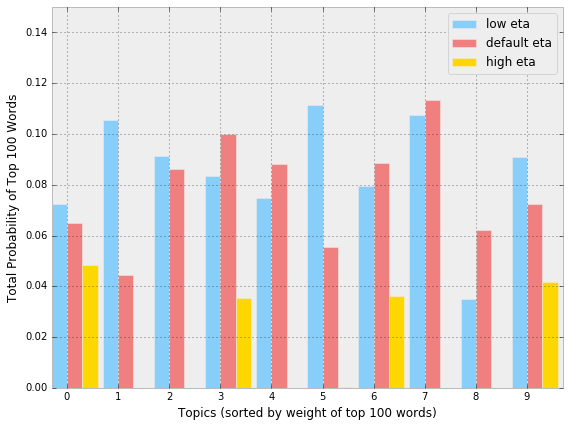

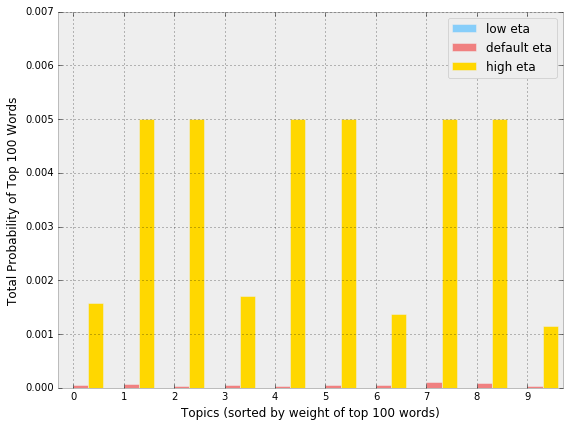

In [27]:
param_barplot( eta_low_top, eta_default_top, eta_high_top, 
               ylim = 0.15, param = 'eta',
               xlab = 'Topics (sorted by weight of top 100 words)', 
               ylab = 'Total Probability of Top 100 Words' )

param_barplot( eta_low_bottom, eta_default_bottom, eta_high_bottom, 
               ylim = 0.007, param = 'eta',
               xlab = 'Topics (sorted by weight of top 100 words)', 
               ylab = 'Total Probability of Top 100 Words' )

From these two plots we can see that the low `eta` model results in higher weight placed on the top words and lower weight placed on the bottom words for each topic. On the other hand, the high `eta` model places relatively less weight on the top words and more weight on the bottom words. Thus increasing `eta` results in topics that have a smoother distribution of weight across all the words in the vocabulary.

We have now seen how the hyperparameters influence the characteristics of our LDA topic model, but we haven't said anything about which settings are best. We know that these parameters are responsible for controlling the smoothness of the topic distributions for documents (`alpha`) and word distributions for topics (`eta`), but there's no simple conversion between smoothness of these distributions and quality of the topic model. In reality, there is no universally "best" choice for these parameters. Finding a good topic model really requires some exploration of the output to see if it make sense (as we did by looking at the top words for topics and checking some topic predictions for documents).

## Reference

- [gensim LDA documentation](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation)
- [Coursera Washington Clustering & Retrieval](https://www.coursera.org/learn/ml-clustering-and-retrieval)
- [KDnuggets Blog: America’s Next Topic Model](http://www.kdnuggets.com/2016/07/americas-next-topic-model.html) (evaluation method not done)